### Imports

In [1]:
import jax
import jax.numpy as jnp
from jax import random
import optax
from realnvp.bijections import RealNVP
import equinox as eqx
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing

### Generate data

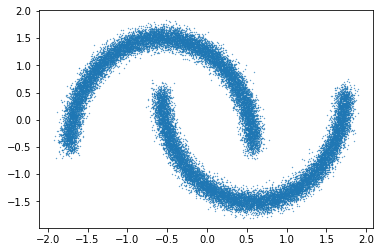

In [22]:
n_samples = 30000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

scaler = preprocessing.StandardScaler()
x, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
x = scaler.fit_transform(x)
x = jnp.array(x)
plt.scatter(x[:, 0], x[:, 1], s=0.1)

### Define loss and training loop

In [23]:

@eqx.filter_jit
@eqx.filter_value_and_grad
def loss_value_and_grad(model, x):
    z, log_abs_det = jax.vmap(model.transform_and_log_abs_det_jacobian)(x)
    p_z = jax.scipy.stats.norm.logpdf(z)
    return -(p_z + log_abs_det).mean()

def train(key, model, x, optim, loss_value_and_grad, epochs=10, batch_size=200):
    params, _ = eqx.partition(model, eqx.is_array)
    opt_state = optim.init(params)
    losses = []
    for epoch in range(epochs):
        key, subkey = random.split(key)
        x = random.permutation(key, x)
        for i in range(0, x.shape[0]-batch_size, batch_size):
            xi = x[i : i+batch_size]
            loss, grads = loss_value_and_grad(model, xi)
            losses.append(loss.item())
            updates, opt_state = optim.update(grads, opt_state)
            model = eqx.apply_updates(model, updates)
        print(f"epoch={epoch}, loss={loss}")
    return model, losses


### Train and plot samples

In [24]:
key = random.PRNGKey(1)
model = RealNVP(key, 2, 10, 1, 15)
optim = optax.adam(1e-3)

key, subkey = random.split(key)
model, losses = train(
    key, model, x, optim, loss_value_and_grad, epochs = 20, batch_size=200)

epoch=0, loss=0.8540277481079102
epoch=1, loss=0.6670325398445129
epoch=2, loss=0.48258307576179504
epoch=3, loss=0.7817525863647461
epoch=4, loss=0.295644611120224
epoch=5, loss=0.12022580206394196
epoch=6, loss=0.041073739528656006
epoch=7, loss=-0.015429360792040825
epoch=8, loss=-0.06973733752965927
epoch=9, loss=0.482888400554657
epoch=10, loss=-0.13314233720302582
epoch=11, loss=0.027578778564929962
epoch=12, loss=-0.11657019704580307
epoch=13, loss=-0.14677110314369202
epoch=14, loss=-0.19800825417041779
epoch=15, loss=-0.0898078978061676
epoch=16, loss=-0.13890936970710754
epoch=17, loss=-0.10301081091165543
epoch=18, loss=-0.1555337756872177
epoch=19, loss=-0.2683708071708679


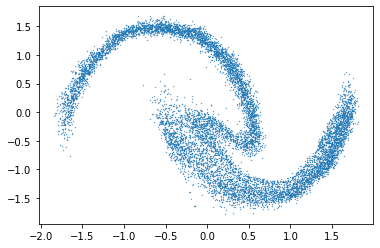

In [25]:
key, subkey = random.split(key)
z = jax.random.normal(key, (10000, 2))
x_samples = jax.vmap(model.inverse)(z)
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)